In [1]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, auc
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import joblib
import datetime


In [2]:
# load data
file_path = "data_processed.csv"
df = pd.read_csv(file_path)
print(f"Dataset Loaded. Shape: {df.shape}")
df.head()

Dataset Loaded. Shape: (225743, 85)


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [3]:
# data cleaning
# removing leading/trailing spaces from colnames
df.columns = df.columns.str.strip()


df.replace([np.inf, -np.inf], np.nan, inplace=True) # replace inf values with NaN and drop missing values
df.dropna(inplace=True)

# dropping duplicates
df.drop_duplicates(inplace=True)
print(f"Shape after cleaning: {df.shape}")

Shape after cleaning: (225743, 85)


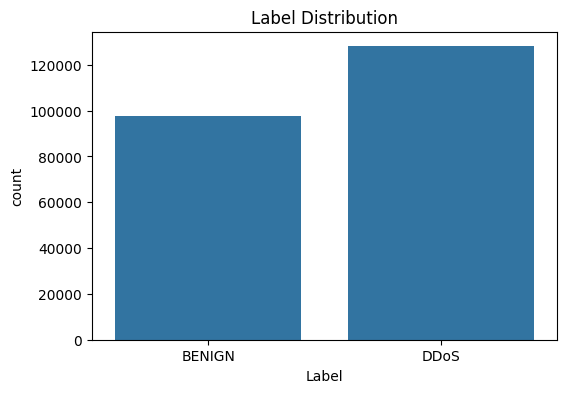

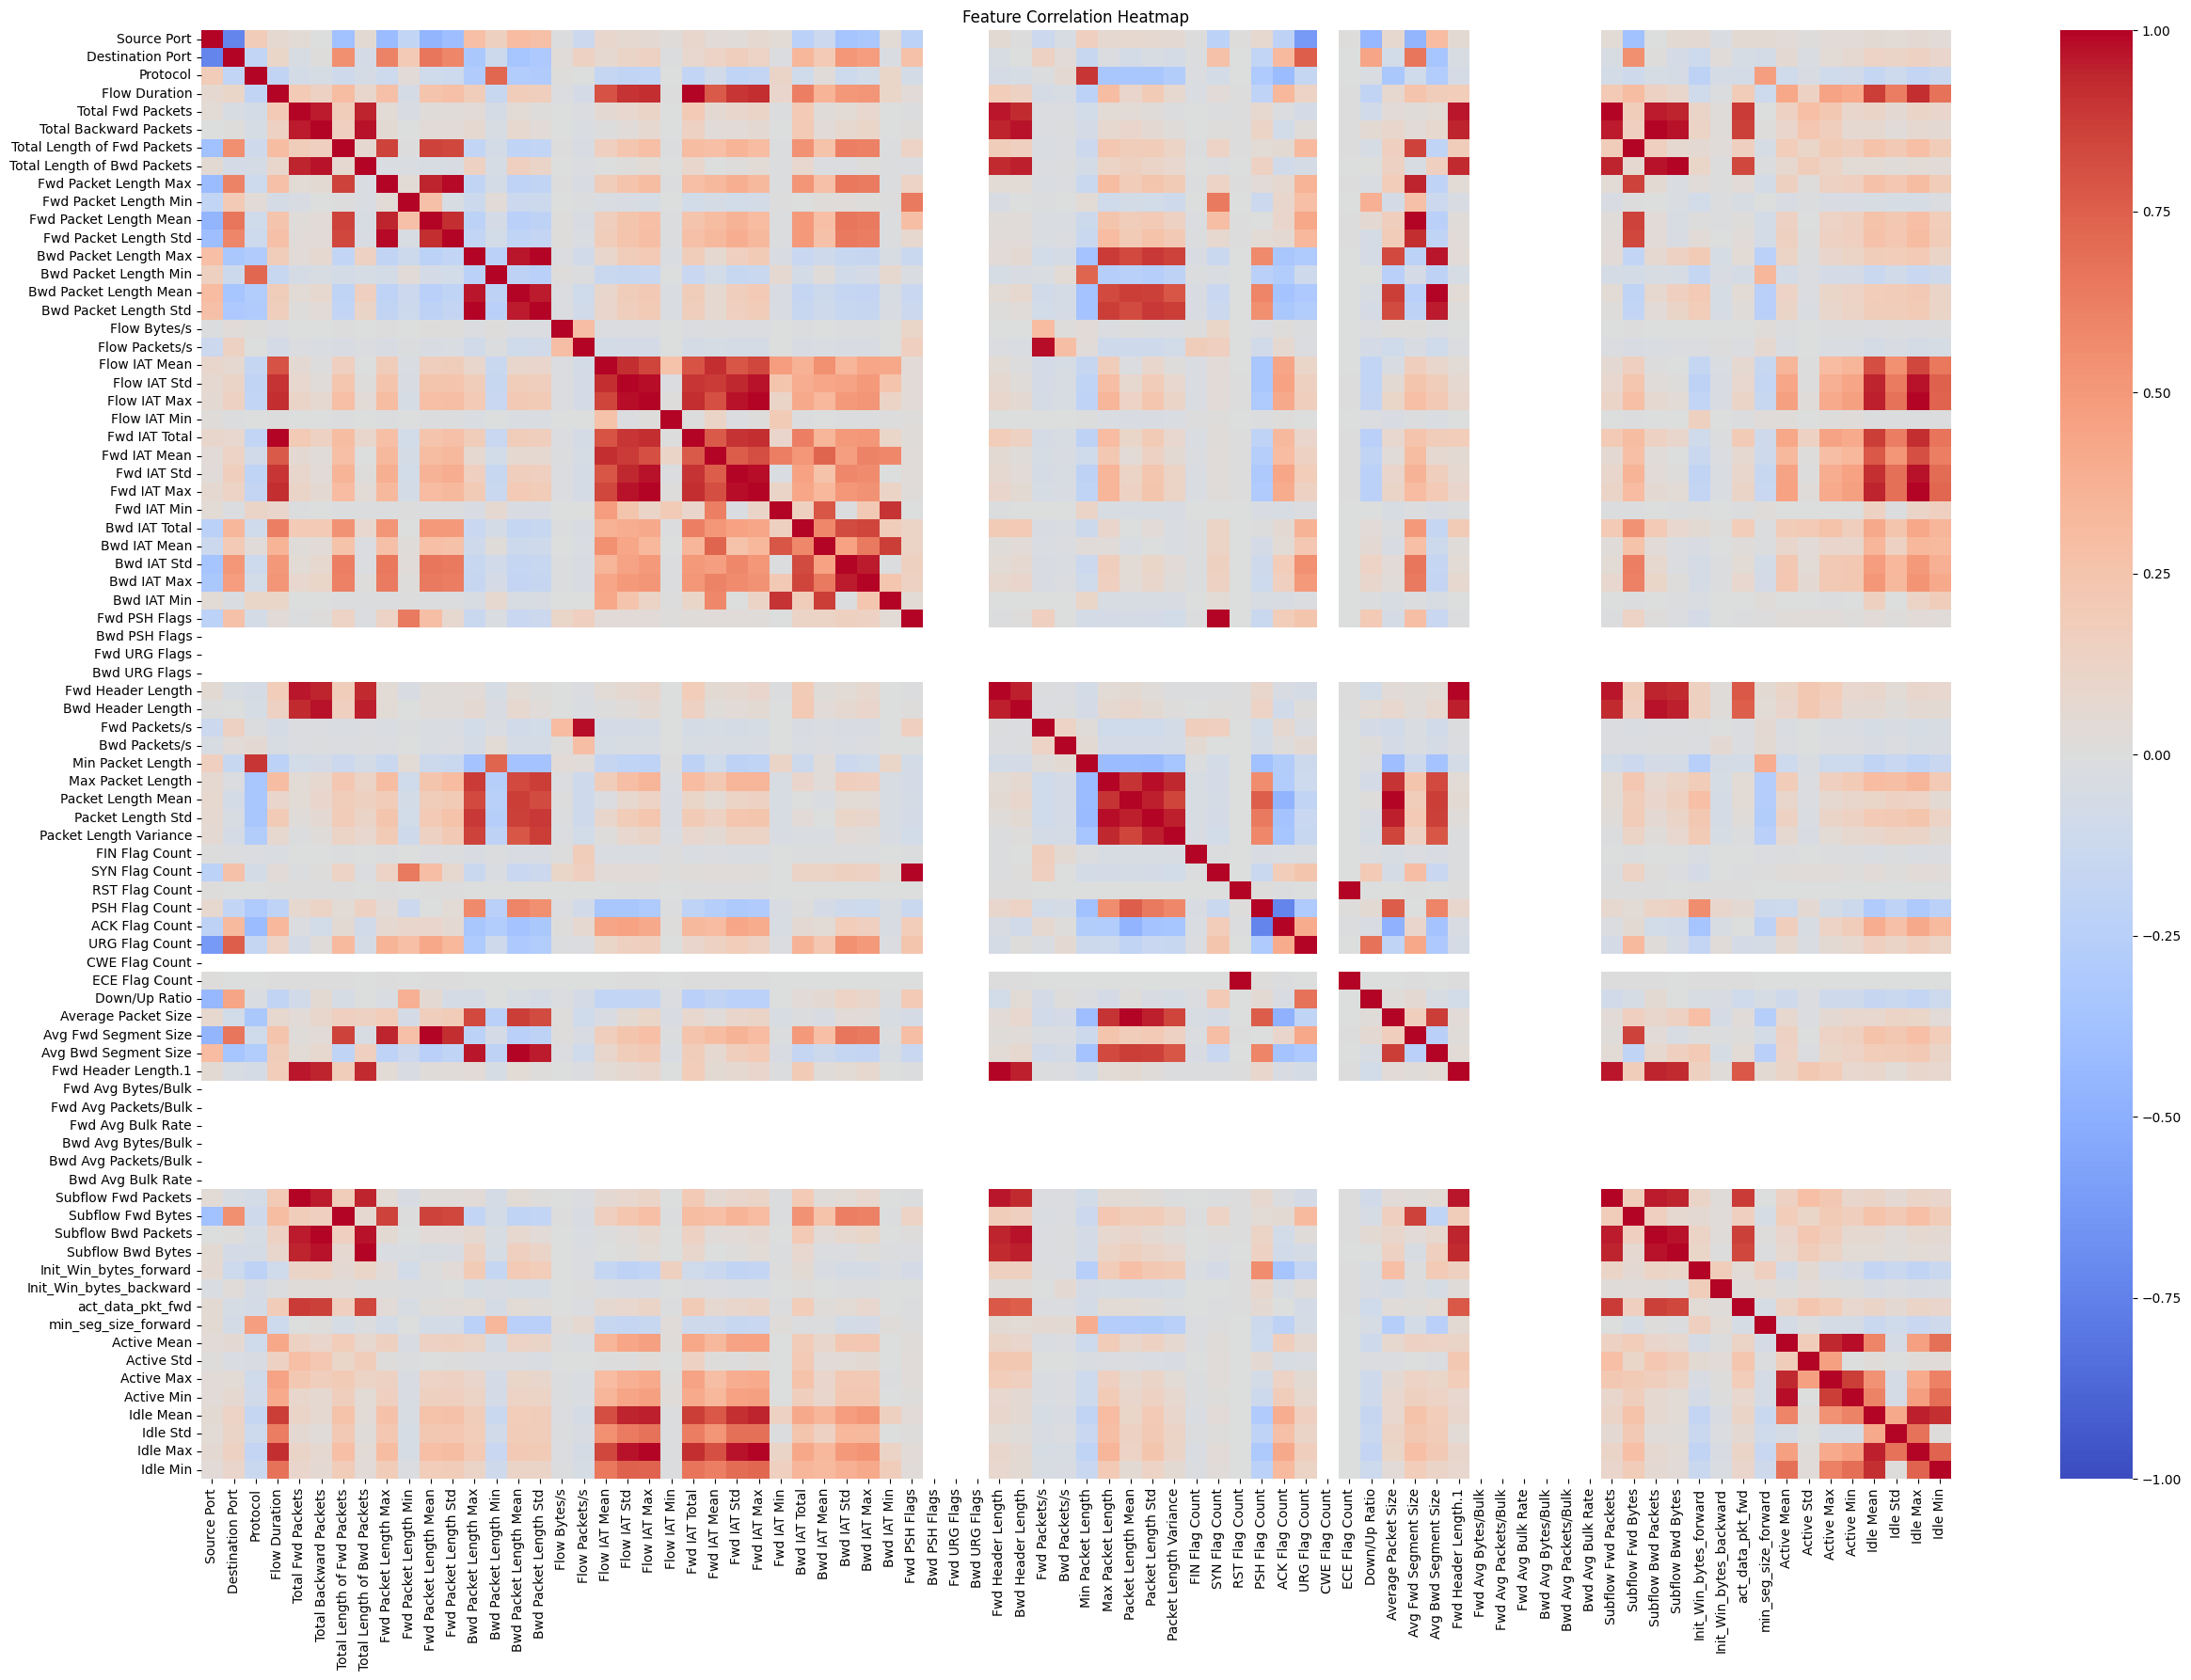

In [4]:
# EDA
# Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x="Label", data=df)
plt.title("Label Distribution")
plt.show()

# numerical features for correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(30, 20))
sns.heatmap(numeric_df.corr(), cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()


In [5]:
le = LabelEncoder() # label encoding for categorical features
df["Label"] = le.fit_transform(df["Label"])

drop_cols = ["Flow ID", "Source IP", "Destination IP", "Timestamp"]
df.drop(columns=drop_cols, errors="ignore", inplace=True)

categorical_features = ["Source Port", "Destination Port"]
for col in categorical_features:
    freq_map = df[col].value_counts().to_dict()
    df[col] = df[col].map(freq_map)

print("Feature engineering completed.")

Feature engineering completed.


In [6]:
# Train test split with stratified splitting to maintain class distribution
X = df.drop(columns=["Label"])
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (158020, 80), Test shape: (67723, 80)


In [8]:
# Hyperparameter tuning with GridSearchCV & Cross-Validation
param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 6, 10],
        "learning_rate": [0.01, 0.1, 0.2]
    },
    "MLP Neural Network": {
        "hidden_layer_sizes": [(64, 32), (128, 64), (256, 128)],
        "max_iter": [300, 500]
    }
}

tuned_models = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, param_grid in param_grids.items():
    model = None
    if name == "Logistic Regression":
        model = LogisticRegression(max_iter=1000)
    elif name == "Random Forest":
        model = RandomForestClassifier(random_state=42)
    elif name == "XGBoost":
        model = XGBClassifier(eval_metric='logloss', random_state=42)
    elif name == "MLP Neural Network":
        model = MLPClassifier(random_state=42)
    
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    tuned_models[name] = grid_search.best_estimator_
    print(f"{name} Best Params: {grid_search.best_params_}")

Logistic Regression Best Params: {'C': 10}
Random Forest Best Params: {'max_depth': 20, 'n_estimators': 200}
XGBoost Best Params: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 50}
MLP Neural Network Best Params: {'hidden_layer_sizes': (128, 64), 'max_iter': 300}


In [7]:
# Bias Mitigation
for name, param_grid in param_grids.items():
    if name in ["Logistic Regression", "Random Forest"]:
        param_grid["class_weight"] = ["balanced"]

NameError: name 'param_grids' is not defined

In [ ]:
# ### Step 8: Model Evaluation and Visualization
# plt.figure(figsize=(8, 6))
# for name, model in tuned_models.items():
#     y_proba = model.predict_proba(X_test)[:, 1]
#     fpr, tpr, _ = roc_curve(y_test, y_proba)
#     plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})", linewidth=2)

# plt.plot([0,1], [0,1], linestyle="--", color='gray', linewidth=1)
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curves for All Models")
# plt.legend()
# plt.show()

In [22]:
# ### Step 9: Model Evaluation and Visualization
# plt.figure(figsize=(8, 6))
# for name, model in tuned_models.items():
#     y_proba = model.predict_proba(X_test)[:, 1]
#     fpr, tpr, _ = roc_curve(y_test, y_proba)
#     plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})")

# plt.plot([0,1], [0,1], linestyle="--", color='gray')
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curves for All Models")
# plt.legend()
# plt.show()

# # Confusion Matrices
# for name, model in tuned_models.items():
#     y_pred = model.predict(X_test)
#     cm = confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(6,4))
#     sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
#     plt.title(f"Confusion Matrix - {name}")
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.show()


In [ ]:
# # Bias Mitigation: Use class weighting
# for name, model in tuned_models.items():
#     if hasattr(model, 'class_weight'):
#         model.class_weight = 'balanced'
#     print(f"Applied bias mitigation for {name}")

# print("Bias mitigation applied.")

# ### Step 9: Save All Models in Run Directory
# import datetime
# run_dir = f"models_run_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
# os.makedirs(run_dir, exist_ok=True)

# for name, model in tuned_models.items():
#     model_path = os.path.join(run_dir, f"{name.replace(' ', '_').lower()}_model.pkl")
#     joblib.dump(model, model_path)
#     print(f"Saved {name} model at {model_path}")

# print(f"All models saved in {run_dir}")

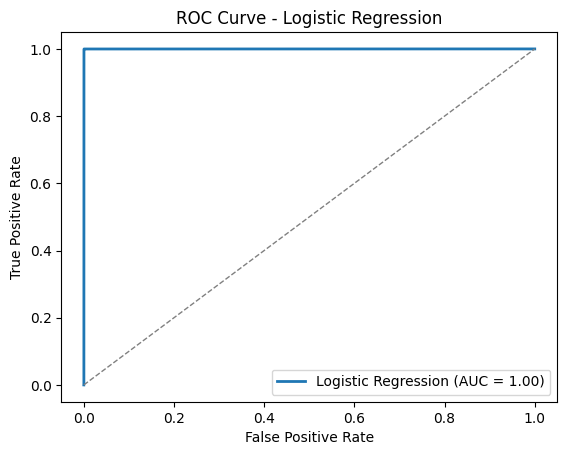

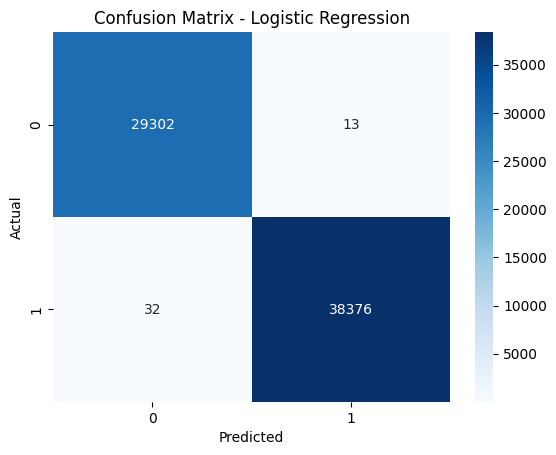

Saved Logistic Regression model and evaluation files in models_run_20250223_164725


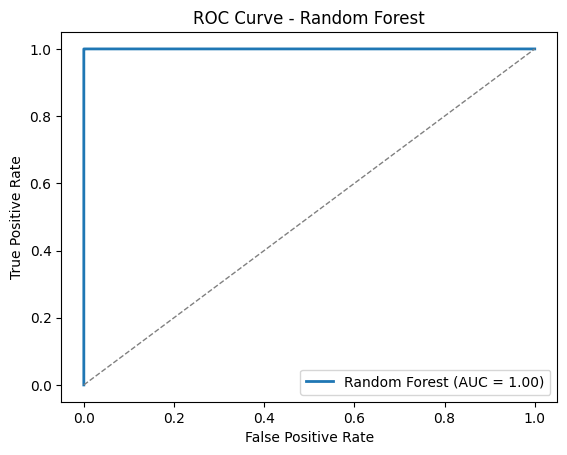

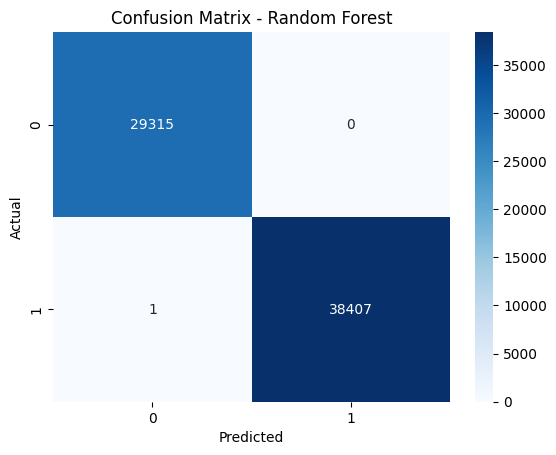

Saved Random Forest model and evaluation files in models_run_20250223_164725


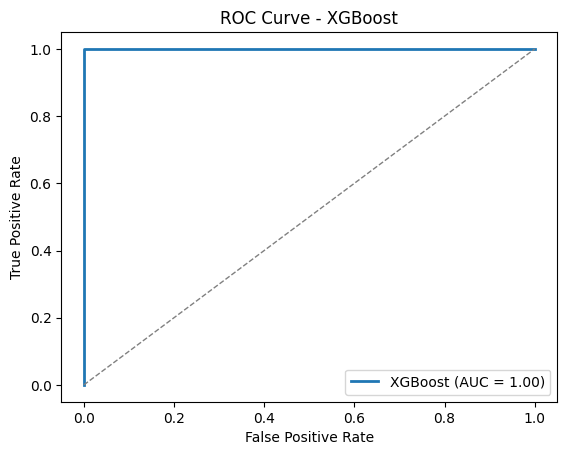

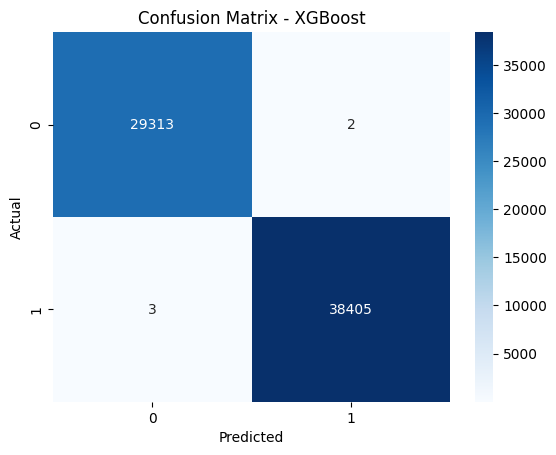

Saved XGBoost model and evaluation files in models_run_20250223_164725


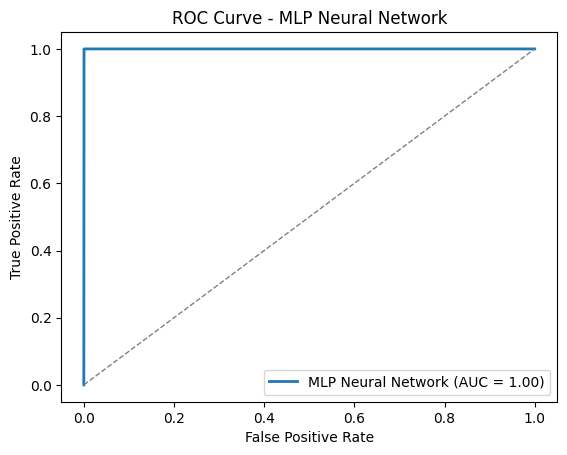

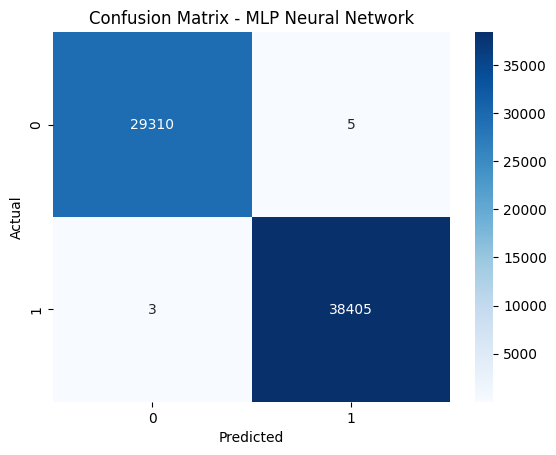

Saved MLP Neural Network model and evaluation files in models_run_20250223_164725


In [11]:
### Step 9: Model Evaluation and Visualization
run_dir = f"models_run_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
os.makedirs(run_dir, exist_ok=True)

for name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    
    # Save ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})", linewidth=2)
    plt.plot([0,1], [0,1], linestyle="--", color='gray', linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.savefig(os.path.join(run_dir, f"roc_curve_{name.replace(' ', '_').lower()}.png"))
    plt.show()
    
    # Save Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(os.path.join(run_dir, f"confusion_matrix_{name.replace(' ', '_').lower()}.png"))
    plt.show()
    
    # Save Classification Report
    report = classification_report(y_test, y_pred)
    with open(os.path.join(run_dir, f"classification_report_{name.replace(' ', '_').lower()}.txt"), 'w') as f:
        f.write(report)

    # Save Model
    joblib.dump(model, os.path.join(run_dir, f"{name.replace(' ', '_').lower()}_model.pkl"))
    print(f"Saved {name} model and evaluation files in {run_dir}")


## Implement Overfitting Checks in Your Code


In [ ]:
# print F1 score for train test sets
for name, model in tuned_models.items():
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    print(f"{name}: Train F1-score = {train_f1:.4f}, Test F1-score = {test_f1:.4f}")

Logistic Regression: Train F1-score = 0.9995, Test F1-score = 0.9995
Random Forest: Train F1-score = 1.0000, Test F1-score = 0.9999
XGBoost: Train F1-score = 1.0000, Test F1-score = 1.0000
MLP Neural Network: Train F1-score = 0.9999, Test F1-score = 0.9999
